# 📈 Strategy Description: Trend-Following on Top 20 Cryptocurrencies with Risk-Adjusted Exposure

This notebook presents a suite of systematic strategies that apply trend-following logic across the top 20 cryptocurrencies by market capitalization. All strategies use **risk-adjusted exposure based on realized volatility**, ensuring position sizing aligns with a target volatility level. This approach balances potential returns with consistent risk control.


## 🔹 1. Long-Only Trend Strategy

A straightforward trend-following model that goes **long only** on assets exhibiting a clear upward trend. The signal is defined by the **breakout of Donchian channels**, evaluated across different timeframes. This method is introduced in the following paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5209907


## 🔸 2. Long-Only Trend Strategy with Confirmation Indicators

This variant adds robustness to the core trend signal by requiring **confirmation from secondary indicators**, such as:

- **OBV (On-Balance Volume)**: Confirms participation via volume flow
- **ADX (Average Directional Index)**: Ensures trend strength is sufficient
- **MACD**: Momentum confirmation

Only when the primary trend signal aligns with supportive readings from these indicators will a long position be taken. Exposure is again adjusted based on realized volatility.


## 🔁 3. Long-Short Trend Strategy (Market-Neutral)

A **market-neutral** strategy based on Z-Scores and EWMA Crossovers, that goes long on assets with most positive trend and short on those with most negative trend. This setup aims to capture relative performance across assets while hedging directional market risk.


All strategies are rebalanced periodically and assume access to clean historical data and sufficient liquidity. Realized volatility is computed over a rolling window, and exposures are scaled dynamically to hit a predefined portfolio-level **target volatility**.


# <br><br> Imports

In [1]:
from requests import get
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.colors import sample_colorscale

import time
import sys
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import vectorbt as vbt
import arcticdb as adb
from scipy.stats import rankdata

import arcticdb as adb

from fredapi import Fred

import ta

# <br><br> Built-in functions

In [2]:
from typing import List, Union

def get_historical_klines(symbol: str, start_date: float, interval: str = '1h', spot: bool = True) -> pd.DataFrame:
    """
    Retrieve historical OHLC data from Binance Spot or Futures (Perpetual) API.

    Parameters
    ----------
    symbol : str
        Trading pair symbol (e.g., 'BTCUSDT').
    start_date : float
        Start date as a Unix timestamp in seconds.
    interval : str, optional
        Kline interval (default is '1h').
    spot : bool, optional
        Market type: True if Spot, False if Perp (default is True).

    Returns
    -------
    pd.DataFrame
        DataFrame with historical OHLCV data and calculated CVD approximation.
    """
    start_ms = int(start_date * 1e3)
    end_ms = int((time.time() - 300) * 1e3)  # 5 min buffer

    base_url = 'https://api4.binance.com/api/v3/klines' if spot else 'https://fapi.binance.com/fapi/v1/klines'

    all_data = []
    current_start = start_ms
    max_retries = 3

    def fetch_klines(start_ts: int, end_ts: int) -> pd.DataFrame:
        url = f"{base_url}?symbol={symbol}&interval={interval}&startTime={start_ts}&endTime={end_ts}&limit=1000"
        for attempt in range(max_retries):
            try:
                res = np.array(get(url).json())
                if len(res) == 0:
                    return pd.DataFrame()
                df = pd.DataFrame({
                    'timestamp': res[:, 0],
                    'open': res[:, 1],
                    'high': res[:, 2],
                    'low': res[:, 3],
                    'close': res[:, 4],
                }).astype(float)
                return df
            except Exception as e:
                if attempt == max_retries - 1:
                    raise Exception(f"Failed to fetch data after {max_retries} attempts.") from e
                time.sleep(5)

    # Main download loop
    while current_start < end_ms:
        batch = fetch_klines(current_start, end_ms)
        if batch.empty:
            break
        all_data.append(batch)
        current_start = int(batch['timestamp'].max()) + 1
        if len(batch) < 1000:
            break

    df = pd.concat(all_data).drop_duplicates('timestamp')
    df.sort_values(by='timestamp', inplace=True)
    df['timestamp'] /= 1e3
    df.index = range(len(df))

    return df


def cumulative_percentile(
    series: pd.Series,
    rolling_window: Union[int, float] = 1e10,
    show_progress: bool = True
) -> pd.Series:
    """
    Computes the cumulative percentile of each value in a time series,
    optionally within a rolling window.

    Parameters
    ----------
    series : pd.Series
        The input time series.
    rolling_window : int or float, optional
        Number of past values to consider (including current). If large (default=1e10),
        computes percentiles over the entire history up to each point.
    show_progress : bool, optional
        Whether to show a tqdm progress bar.

    Returns
    -------
    pd.Series
        A series of percentiles (0–100) for each value, aligned with the original index.
    """
    percentiles = []
    iterator = tqdm(range(len(series))) if show_progress else range(len(series))

    for i in iterator:
        # Define the rolling window range
        start = max(0, int(i - rolling_window))
        current_values = series[start:i + 1].dropna()

        # Handle edge cases
        if len(current_values) == 0 or np.isnan(series.values[i]):
            percentiles.append(np.nan)
            continue

        # Rank the current values
        ranks = rankdata(current_values)
        percentile = (ranks[-1] - 1) / (len(current_values) - 1) * 100
        percentiles.append(percentile)

    return pd.Series(percentiles, index=series.index)

# <br><br> 1. Trend-Follow based on Donchian channels breakout, Long-Only

<br>Calculation of signal based on breakout of Donchian-Channels with different time windows. When the price xover the upper band of a channel, a long position is opened, using the average between the lower and the upper band as a trailing stop. This signal, which is 0 or 1, is averaged across different time windows. The exact methodology is explained in https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5209907

In [3]:
# Price history of coins that has been in the Top 20 by market cap. 
# There is a column with a flag, 0 or 1, depending on the coing being in the Top 20 or not at that specific date.
data = pd.read_csv('../data/data_20.csv')
coins = [k.replace('_close', '') for k in data.keys() if '_close' in k]
data.index = range(len(data))

# ------------------------------------------------
# Realized Volatility
for coin in coins:
    data[f'{coin}_vol'] = data[f'{coin}_close'].pct_change().ewm(span=90).std() * np.sqrt(365)

# ------------------------------------------------
# Calculation of main signal based on breakout of Donchian channels with different time windows
spans = [
    5,
    10,
    20,
    40,
    80,
    160
]

for coin in tqdm(coins):
    for span in spans:
        data[f'{coin}_max_{span}'] = data[f'{coin}_close'].rolling(span).max()
        data[f'{coin}_min_{span}'] = data[f'{coin}_close'].rolling(span).min()
        data[f'{coin}_avg_{span}'] = 0.5 * (data[f'{coin}_max_{span}'] + data[f'{coin}_min_{span}'])
        
        signals = []
        for i, row in data.iterrows():
            if i == 0:
                signals.append(0)
                continue
            elif signals[-1] == 0 and row[f'{coin}_close'] == row[f'{coin}_max_{span}']:
                signals.append(1)
                trailing_stop = row[f'{coin}_avg_{span}']
            elif (signals[-1] == 1) and (row[f'{coin}_close'] <= max(trailing_stop, row[f'{coin}_avg_{span}'])):
                signals.append(0)
            else:
                signals.append(signals[-1])
        
        data[f'{coin}_signal_{span}'] = signals
    
    data[f'{coin}_signal'] = data[[f'{coin}_signal_{span}' for span in spans]].mean(axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [02:35<00:00,  2.04s/it]


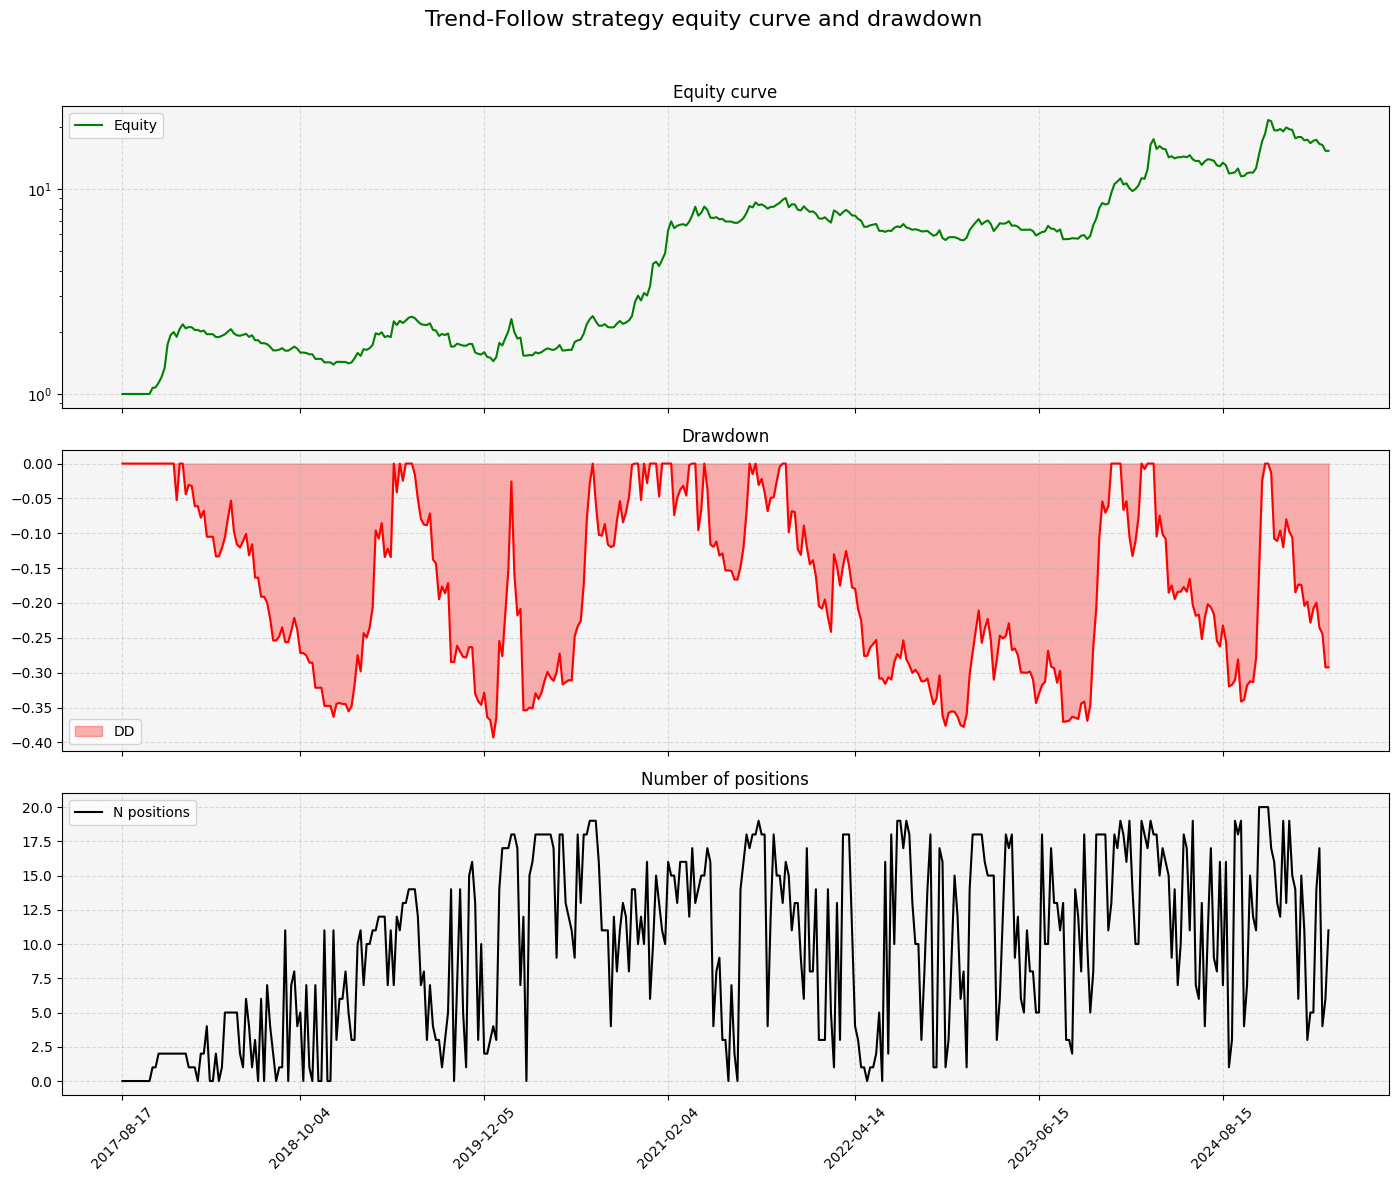

In [4]:
data_copy = data.copy()

# Weekly rebalance
# This allows for manual execution of the strategy, and reduces fees
data_copy = data_copy.iloc[::7]

# ------------------------------------------
for coin in coins:
    # Filter coins not in Top 20
    mask_1 = data_copy[coin] == 0
    # Filter recently listed coins
    mask_2 = data_copy[f'{coin}_close'].isna() | data_copy[f'{coin}_close'].shift(10).isna()
    # Filter coins with too large or small volatility
    mask_3 = (data_copy[f'{coin}_vol'] > 2) | (data_copy[f'{coin}_vol'] < 0.2)
    
    mask = mask_1 | mask_2 | mask_3
    data_copy.loc[mask, f'{coin}_signal'] = 0

# ------------------------------------------
# Total positions opened
data_copy['n_positions'] = data_copy[[f'{coin}_signal' for coin in coins]].ne(0).sum(axis=1)

# Portfolio target volatility
target_vol = 0.5
multiplier = 2 # Trend-signal has an EV of 0.5, without doing further calculations, so we must adjust target_vol by a factor
target_vol_adj = target_vol * multiplier

# Based on Hyperliquid Taker fees
fee = 0.035
slippage = 0.05

for coin in coins:
    # Risk-adjusted exposure
    data_copy[f'{coin}_position'] = data_copy[f'{coin}_signal'] * target_vol_adj / data_copy['n_positions'] / data_copy[f'{coin}_vol']

    buy_price = data_copy[f'{coin}_close'] * (1 + fee/100 + slippage/100)
    sell_price = data_copy[f'{coin}_close'].shift(-1) * (1 - fee/100 - slippage/100)
    data_copy[f'{coin}_r'] = data_copy[f'{coin}_position'] * (sell_price/buy_price - 1)

# ------------------------------------------
# Calculation of equity curve
data_copy['week_r'] = data_copy[[f'{coin}_r' for coin in coins]].sum(axis=1)
data_copy['equity'] = (data_copy['week_r'] + 1).cumprod()

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
# Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Calcular drawdown
equity = data_copy.equity.values
running_max = np.maximum.accumulate(equity)
data_copy['drawdown'] = (equity - running_max) / running_max

# --- Crear figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
plt.subplots_adjust(hspace=0.4)
fig.suptitle(f"Trend-Follow strategy equity curve and drawdown", fontsize=16)

# --- Subplot 1: Asset vs Strategy (log scale)
axes[0].plot(data_copy['date'], data_copy['equity'], label='Equity', color='green', linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_title("Equity curve", fontsize=12)
axes[0].legend()

# --- Subplot 2: Position
axes[1].fill_between(data_copy['date'], 0, data_copy['drawdown'], label='DD', color='red', alpha=0.3)
axes[1].plot(data_copy['date'], data_copy['drawdown'], color='red', linewidth=1.5)
axes[1].set_title('Drawdown', fontsize=12)
axes[1].legend()

# --- Subplot 3: Breadth model & BTC Trend
axes[2].plot(data_copy['date'], data_copy['n_positions'], label='N positions', color='black', linewidth=1.5)
axes[2].set_title('Number of positions', fontsize=12)
axes[2].legend()

# --- Eje X: formato fecha
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

# --- Estilo común
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_facecolor('whitesmoke')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [5]:
pf = vbt.Portfolio.from_signals(
    close=data_copy['equity'].dropna(),
    entries=True,
    exits=False,
    freq='7d'
)
pf_btc = vbt.Portfolio.from_signals(
    close=data_copy['BTC_close'].dropna(),
    entries=True,
    exits=False,
    freq='7d'
)

def print_perf_metrics(title, pf_obj):
    print(f'{title}\n' + '-' * len(title))
    print(f'{"Annualized return:":<25} {100 * pf_obj.annualized_return():6.2f} %')
    print(f'{"Annualized volatility:":<25} {100 * pf_obj.annualized_volatility():6.2f} %')
    print(f'{"Maximum Drawdown:":<25} {100 * pf_obj.max_drawdown():6.2f} %')
    print(f'{"Sharpe ratio:":<25} {pf_obj.sharpe_ratio():6.2f}')
    print(f'{"Calmar ratio:":<25} {pf_obj.calmar_ratio():6.2f}')
    print()

print_perf_metrics('📊 Trend-Follow Strategy (Long-only)', pf)
print_perf_metrics('🎯 Benchmark: BTC', pf_btc)

📊 Trend-Follow Strategy (Long-only)
-----------------------------------
Annualized return:         42.62 %
Annualized volatility:     41.15 %
Maximum Drawdown:         -39.30 %
Sharpe ratio:               1.06
Calmar ratio:               1.08

🎯 Benchmark: BTC
----------------
Annualized return:         47.27 %
Annualized volatility:     73.10 %
Maximum Drawdown:         -80.11 %
Sharpe ratio:               0.89
Calmar ratio:               0.59



# <br><br> 2. Trend-Follow based on Donchian channels breakout + trend confirmation signals, Long-Only

This strategy is similar to the previous one, but some confirmation signals are used to open Long positions. This improves Risk/Return ratio.

In [6]:
# Price history of coins that has been in the Top 20 by market cap. 
# There is a column with a flag, 0 or 1, depending on the coing being in the Top 20 or not at that specific date.
data = pd.read_csv('../data/data_20.csv')
coins = [k.replace('_close', '') for k in data.keys() if '_close' in k]
data.index = range(len(data))

# ------------------------------------------------
# Realized Volatility
for coin in coins:
    data[f'{coin}_vol'] = data[f'{coin}_close'].pct_change().ewm(span=90).std() * np.sqrt(365)

# ------------------------------------------------
# Calculation of main signal based on breakout of Donchian channels with different time windows
spans = [
    5,
    10,
    20,
    40,
    80,
    160
]

for coin in tqdm(coins):
    for span in spans:
        data[f'{coin}_max_{span}'] = data[f'{coin}_close'].rolling(span).max()
        data[f'{coin}_min_{span}'] = data[f'{coin}_close'].rolling(span).min()
        data[f'{coin}_avg_{span}'] = 0.5 * (data[f'{coin}_max_{span}'] + data[f'{coin}_min_{span}'])
        
        signals = []
        for i, row in data.iterrows():
            if i == 0:
                signals.append(0)
                continue
            elif signals[-1] == 0 and row[f'{coin}_close'] == row[f'{coin}_max_{span}']:
                signals.append(1)
                trailing_stop = row[f'{coin}_avg_{span}']
            elif (signals[-1] == 1) and (row[f'{coin}_close'] <= max(trailing_stop, row[f'{coin}_avg_{span}'])):
                signals.append(0)
            else:
                signals.append(signals[-1])
        
        data[f'{coin}_signal_{span}'] = signals
    
    data[f'{coin}_signal'] = data[[f'{coin}_signal_{span}' for span in spans]].mean(axis=1)

    # ----------------------------------------------
    # ADX
    adx_indicator = ta.trend.ADXIndicator(
        high=data[f'{coin}_high'], 
        low=data[f'{coin}_low'], 
        close=data[f'{coin}_close'], 
        window=14
    )
    data[f'{coin}_adx'] = adx_indicator.adx()
    data[f'{coin}_di_plus'] = adx_indicator.adx_pos()
    data[f'{coin}_di_minus'] = adx_indicator.adx_neg()
    # adx > 20-25, di+ > di-

    # ----------------------------------------------
    # OBV
    data[f'{coin}_tc'] = 0
    data.loc[data[f'{coin}_close'] > data[f'{coin}_close'].shift(), f'{coin}_tc'] = 1
    data.loc[data[f'{coin}_close'] < data[f'{coin}_close'].shift(), f'{coin}_tc'] = -1
    data[f'{coin}_obv'] = data[f'{coin}_vol'] * data[f'{coin}_tc']
    data[f'{coin}_obv'] = data[f'{coin}_obv'].cumsum()
    
    data[f'{coin}_obv_zscore'] = (data[f'{coin}_obv'] - data[f'{coin}_obv'].ewm(span=20).mean()) / data[f'{coin}_obv'].ewm(span=20).std()

    # ----------------------------------------------
    # MACD
    data[f'{coin}_macd_line'] = data[f'{coin}_close'].ewm(span=12).mean() - data[f'{coin}_close'].ewm(span=26).mean()
    data[f'{coin}_macd_signal'] = data[f'{coin}_macd_line'].ewm(span=9).mean()
    data[f'{coin}_macd'] = data[f'{coin}_macd_line'] - data[f'{coin}_macd_signal']

    # ----------------------------------------------
    # Confirmation signals
    data[f'{coin}_adx_confirmation'] = 0
    mask_1 = (data[f'{coin}_adx'] > 20) & (data[f'{coin}_adx'] < 25) & (data[f'{coin}_di_plus'] > data[f'{coin}_di_minus'])
    mask_2 = (data[f'{coin}_adx'] > 25) & (data[f'{coin}_di_plus'] > data[f'{coin}_di_minus'])
    data.loc[mask_1, f'{coin}_adx_confirmation'] = 1
    data.loc[mask_2, f'{coin}_adx_confirmation'] = 2

    data[f'{coin}_obv_confirmation'] = 0
    mask_1 = (data[f'{coin}_obv_zscore'] > 0) & (data[f'{coin}_obv_zscore'] < 1)
    mask_2 = (data[f'{coin}_obv_zscore'] > 1)
    data.loc[mask_1, f'{coin}_obv_confirmation'] = 1
    data.loc[mask_2, f'{coin}_obv_confirmation'] = 2

    data[f'{coin}_macd_confirmation'] = 0
    mask_1 = (data[f'{coin}_macd'] > 0) & (data[f'{coin}_macd'].diff() < 0)
    mask_2 = (data[f'{coin}_macd'] > 0) & (data[f'{coin}_macd'].diff() > 0)
    data.loc[mask_1, f'{coin}_macd_confirmation'] = 1
    data.loc[mask_2, f'{coin}_macd_confirmation'] = 2

    data[f'{coin}_confirmation'] = (data[f'{coin}_adx_confirmation'] + 
                                    data[f'{coin}_obv_confirmation'] + 
                                    data[f'{coin}_macd_confirmation']) / 3

    # ----------------------------------------------
    # Donchian-signal x Confirmation-signal
    data[f'{coin}_signal_confirmed'] = data[f'{coin}_signal'] * data[f'{coin}_confirmation']


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [03:21<00:00,  2.65s/it]


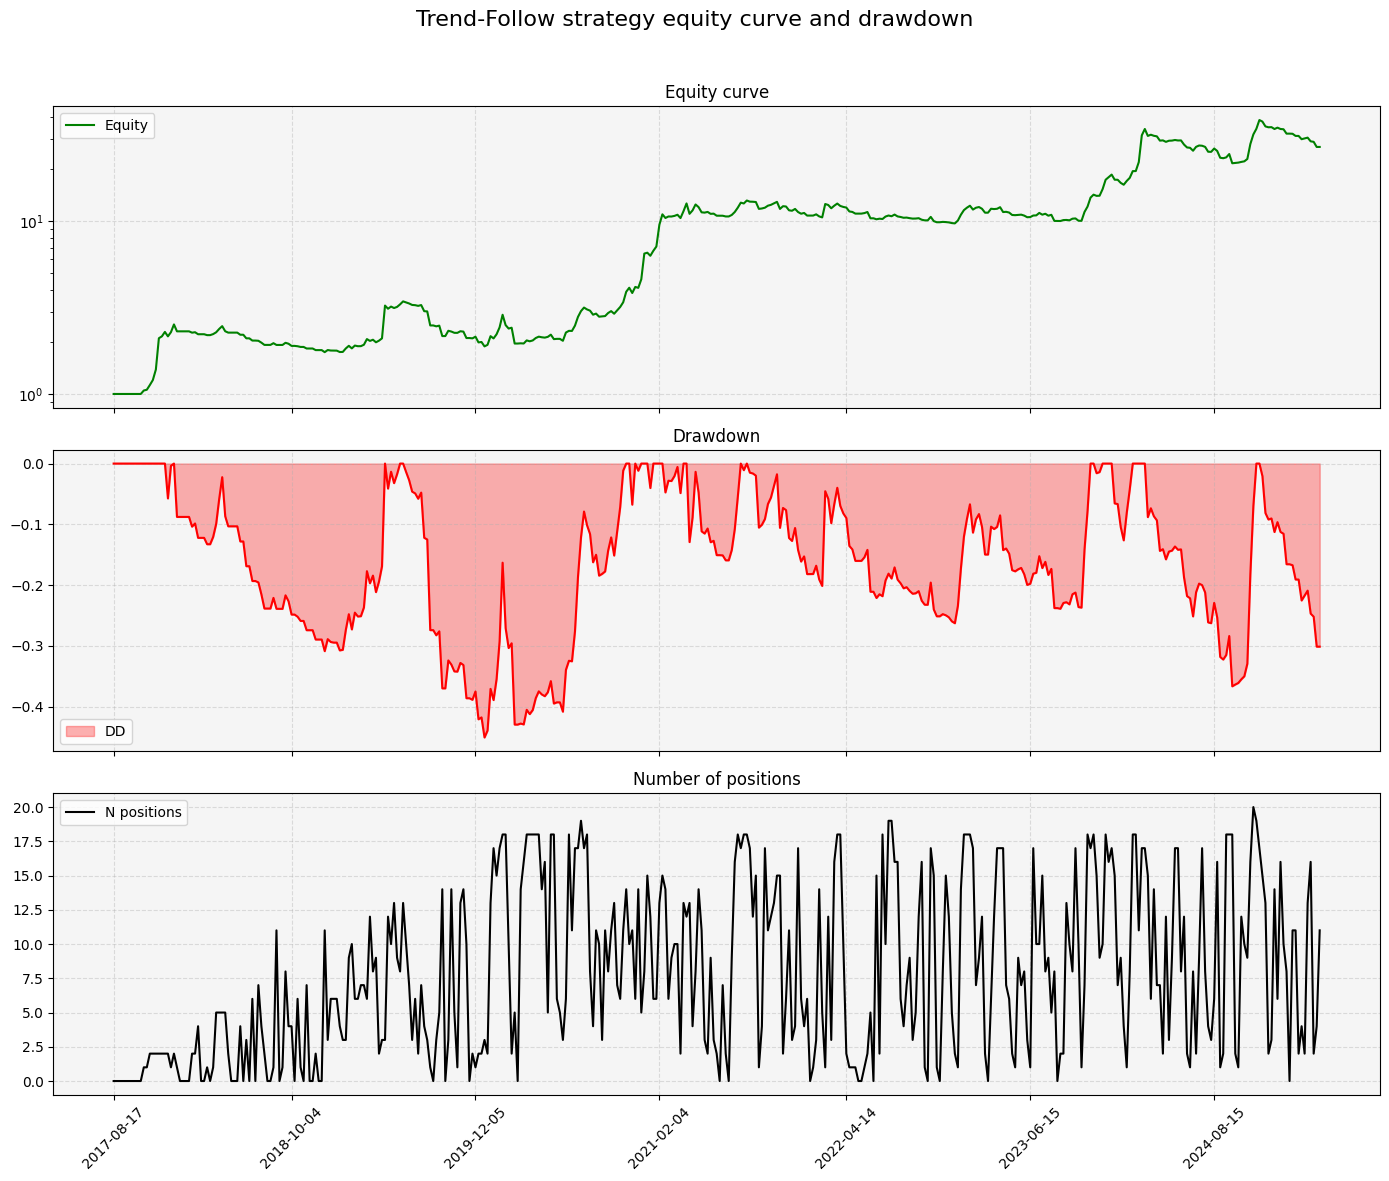

In [7]:
data_copy = data.copy()

# Weekly rebalance
# This allows for manual execution of the strategy, and reduces fees
data_copy = data_copy.iloc[::7]

# ------------------------------------------
for coin in coins:
    # Filter coins not in Top 20
    mask_1 = data_copy[coin] == 0
    # Filter recently listed coins
    mask_2 = data_copy[f'{coin}_close'].isna() | data_copy[f'{coin}_close'].shift(10).isna()
    # Filter coins with too large or small volatility
    mask_3 = (data_copy[f'{coin}_vol'] > 2) | (data_copy[f'{coin}_vol'] < 0.2)
    
    mask = mask_1 | mask_2 | mask_3
    data_copy.loc[mask, f'{coin}_signal_confirmed'] = 0

# ------------------------------------------
# Total positions opened
data_copy['n_positions'] = data_copy[[f'{coin}_signal_confirmed' for coin in coins]].ne(0).sum(axis=1)

# Portfolio target volatility
target_vol = 0.5
multiplier = 2 # Trend-signal has an EV of 0.5, without doing further calculations, so we must adjust target_vol by a factor
target_vol_adj = target_vol * multiplier

# Based on Hyperliquid Taker fees
fee = 0.035
slippage = 0.05

for coin in coins:
    # Risk-adjusted exposure
    data_copy[f'{coin}_position'] = data_copy[f'{coin}_signal_confirmed'] * target_vol_adj / data_copy['n_positions'] / data_copy[f'{coin}_vol']

    buy_price = data_copy[f'{coin}_close'] * (1 + fee/100 + slippage/100)
    sell_price = data_copy[f'{coin}_close'].shift(-1) * (1 - fee/100 - slippage/100)
    data_copy[f'{coin}_r'] = data_copy[f'{coin}_position'] * (sell_price/buy_price - 1)

# ------------------------------------------
# Calculation of equity curve
data_copy['week_r'] = data_copy[[f'{coin}_r' for coin in coins]].sum(axis=1)
data_copy['equity'] = (data_copy['week_r'] + 1).cumprod()

# ---------------------------------------------------------
# Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Calcular drawdown
equity = data_copy.equity.values
running_max = np.maximum.accumulate(equity)
data_copy['drawdown'] = (equity - running_max) / running_max

# --- Crear figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
plt.subplots_adjust(hspace=0.4)
fig.suptitle(f"Trend-Follow strategy equity curve and drawdown", fontsize=16)

# --- Subplot 1: Asset vs Strategy (log scale)
axes[0].plot(data_copy['date'], data_copy['equity'], label='Equity', color='green', linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_title("Equity curve", fontsize=12)
axes[0].legend()

# --- Subplot 2: Position
axes[1].fill_between(data_copy['date'], 0, data_copy['drawdown'], label='DD', color='red', alpha=0.3)
axes[1].plot(data_copy['date'], data_copy['drawdown'], color='red', linewidth=1.5)
axes[1].set_title('Drawdown', fontsize=12)
axes[1].legend()

# --- Subplot 3: Breadth model & BTC Trend
axes[2].plot(data_copy['date'], data_copy['n_positions'], label='N positions', color='black', linewidth=1.5)
axes[2].set_title('Number of positions', fontsize=12)
axes[2].legend()

# --- Eje X: formato fecha
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

# --- Estilo común
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_facecolor('whitesmoke')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
pf = vbt.Portfolio.from_signals(
    close=data_copy['equity'].dropna(),
    entries=True,
    exits=False,
    freq='7d'
)
pf_btc = vbt.Portfolio.from_signals(
    close=data_copy['BTC_close'].dropna(),
    entries=True,
    exits=False,
    freq='7d'
)

def print_perf_metrics(title, pf_obj):
    print(f'{title}\n' + '-' * len(title))
    print(f'{"Annualized return:":<25} {100 * pf_obj.annualized_return():6.2f} %')
    print(f'{"Annualized volatility:":<25} {100 * pf_obj.annualized_volatility():6.2f} %')
    print(f'{"Maximum Drawdown:":<25} {100 * pf_obj.max_drawdown():6.2f} %')
    print(f'{"Sharpe ratio:":<25} {pf_obj.sharpe_ratio():6.2f}')
    print(f'{"Calmar ratio:":<25} {pf_obj.calmar_ratio():6.2f}')
    print()

print_perf_metrics('📊 Trend-Follow Strategy + confirmation signals (Long-only)', pf)
print_perf_metrics('🎯 Benchmark: BTC', pf_btc)

📊 Trend-Follow Strategy + confirmation signals (Long-only)
----------------------------------------------------------
Annualized return:         53.42 %
Annualized volatility:     49.95 %
Maximum Drawdown:         -45.09 %
Sharpe ratio:               1.08
Calmar ratio:               1.18

🎯 Benchmark: BTC
----------------
Annualized return:         47.27 %
Annualized volatility:     73.10 %
Maximum Drawdown:         -80.11 %
Sharpe ratio:               0.89
Calmar ratio:               0.59



# <br><br> 3. Trend-Follow based on Z-Scores and EWMAC, Long+Short

In [9]:
# Price history of coins that has been in the Top 20 by market cap. 
# There is a column with a flag, 0 or 1, depending on the coing being in the Top 20 or not at that specific date.
data = pd.read_csv('../data/data_20.csv')
coins = [k.replace('_close', '') for k in data.keys() if '_close' in k]
data.index = range(len(data))

# ------------------------------------------------
# Realized Volatility
for coin in coins:
    data[f'{coin}_vol'] = data[f'{coin}_close'].pct_change().ewm(span=90).std() * np.sqrt(365)

# ------------------------------------------------
# Calculation of Trend-Signal, combining Z-Scores and EWMA Crossovers
z_score_spans = [
    10,
    20,
    40
]
ewmac_spans = [
    2,
    4,
    8
]
for coin in tqdm(coins):
    # ----------------------------------------------
    # Trend signal
    for span in z_score_spans:
        # Z-Score
        data[f'{coin}_zscore_{span}'] = (data[f'{coin}_close'] - data[f'{coin}_close'].ewm(span=span).mean()) / \
                                        data[f'{coin}_close'].ewm(span=span).std()
        data[f'{coin}_zscore_{span}'] /= np.abs(data[f'{coin}_zscore_{span}']).expanding().mean()

        data[f'{coin}_zscore_{span}'] = data[f'{coin}_zscore_{span}'].clip(-2,2)

    for span in ewmac_spans:
        # EWMA Crossover
        data[f'{coin}_ewmac_{span}'] = (data[f'{coin}_close'].ewm(span=span).mean() - data[f'{coin}_close'].ewm(span=4*span).mean()) / \
                                    data[f'{coin}_close'].ewm(span=4*span).std()
        data[f'{coin}_ewmac_{span}'] /= np.abs(data[f'{coin}_ewmac_{span}']).expanding().mean()

        data[f'{coin}_ewmac_{span}'] = data[f'{coin}_ewmac_{span}'].clip(-2,2)

    # Average of all signals
    signals = [f'zscore_{span}' for span in z_score_spans] + [f'ewmac_{span}' for span in ewmac_spans]
    data[f'{coin}_trend'] = data[[f'{coin}_{signal}' for signal in signals]].mean(axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:01<00:00, 45.88it/s]


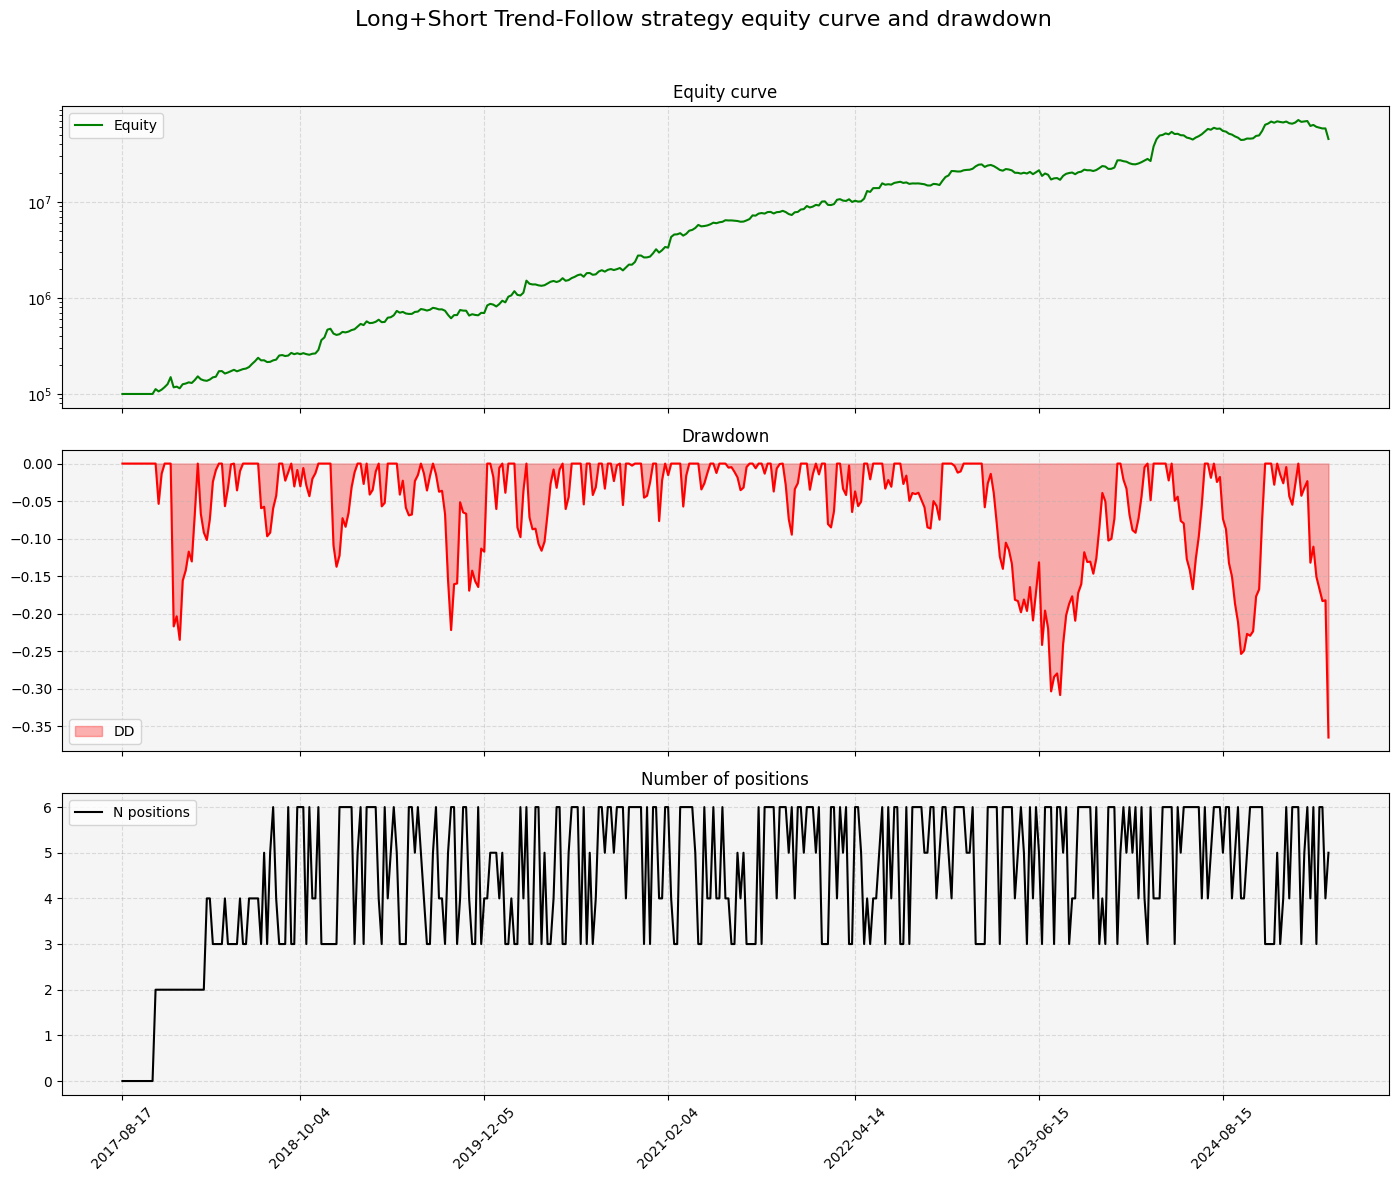

In [10]:
# ----------------------------------------------------------------
data_copy = data.copy()

# Weekly rebalance
# This allows for manual execution of the strategy, and reduces fees
data_copy = data_copy.iloc[::7]
data_copy.index = range(len(data_copy))

# Portfolio target volatility
target_vol = 0.5

fee = 0.035 # Hyperliquid Taker fee
slippage = 0.1 # Conservative slippage assumption

# ------------------------------------------
for coin in coins:
    # Filter recently listed coins
    mask_1 = data_copy[f'{coin}_close'].isna() | data_copy[f'{coin}_close'].shift(10).isna()
    # Filter coins with too large or small volatility
    mask_2 = (data_copy[f'{coin}_vol'] > 2) | (data_copy[f'{coin}_vol'] < 0.2)
    
    data_copy.loc[mask_1 | mask_2, f'{coin}_trend'] = 0

# ------------------------------------------
# Calculation of weekly returns
equity = [1e5] # Initial equity of 10k$
total_positions =  [0]
for i, row in data_copy.iterrows():
    if i >= len(data_copy)-1:
        break
    
    # Top 20 coins by market cap
    top20_coins = [coin for coin in coins if row[coin] == 1]

    # Long signals, when Trend > 0
    long_signals = {coin: row[f'{coin}_trend'] for coin in top20_coins if row[f'{coin}_trend'] > 0}
    # Short signals, when Trend < 0
    short_signals = {coin: row[f'{coin}_trend'] for coin in top20_coins if row[f'{coin}_trend'] < 0}

    # Sort coins for Long positions, take best 3
    long_coins = sorted(long_signals.items(), key=lambda x: x[1], reverse=True)[:3]
    # Sort coins for Short positions, take worst 3
    short_coins = sorted(short_signals.items(), key=lambda x: x[1], reverse=False)[:3]

    long_coins, short_coins = [coin[0] for coin in long_coins], [coin[0] for coin in short_coins]

    # Calculate strategy 1-week return
    dollar_profit = 0
    for coin in long_coins:
        if pd.isna(data_copy.loc[i+1, f'{coin}_close']):
            continue
        dollar_position = equity[-1] * target_vol / row[f'{coin}_vol'] / len(long_coins)
        buy_price = data_copy.loc[i, f'{coin}_close'] * (1 + fee/100 + slippage/100)
        sell_price = data_copy.loc[i+1, f'{coin}_close'] * (1 - fee/100 - slippage/100)
        dollar_profit += ((sell_price - buy_price) / buy_price) * dollar_position
    
    for coin in short_coins:
        if pd.isna(data_copy.loc[i+1, f'{coin}_close']):
            continue
        # Short position, so Buy today and Sell tomorrow
        dollar_position = equity[-1] * target_vol / row[f'{coin}_vol'] / len(short_coins)
        sell_price = data_copy.loc[i, f'{coin}_close'] * (1 - fee/100 - slippage/100)
        buy_price = data_copy.loc[i+1, f'{coin}_close'] * (1 + fee/100 + slippage/100)
        dollar_profit += ((sell_price - buy_price) / buy_price) * dollar_position

    if pd.isna(dollar_profit):
        dollar_profit = 0
    
    equity.append(equity[-1] + dollar_profit)
    total_positions.append(len(long_coins) + len(short_coins))

# ------------------------------------------
# Calculation of equity curve
data_copy['n_positions'] = total_positions
# data_copy['week_r'] = total_returns
# data_copy.dropna(subset=['week_r'], inplace=True)
data_copy['equity'] = equity

# ------------------------------------------
# Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Calcular drawdown
equity = data_copy.equity.values
running_max = np.maximum.accumulate(equity)
data_copy['drawdown'] = (equity - running_max) / running_max

# --- Crear figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Long+Short Trend-Follow strategy equity curve and drawdown", fontsize=16)

# --- Subplot 1: Asset vs Strategy (log scale)
axes[0].plot(data_copy['date'], data_copy['equity'], label='Equity', color='green', linewidth=1.5)
axes[0].set_yscale('log')
axes[0].set_title("Equity curve", fontsize=12)
axes[0].legend()

# --- Subplot 2: Position
axes[1].fill_between(data_copy['date'], 0, data_copy['drawdown'], label='DD', color='red', alpha=0.3)
axes[1].plot(data_copy['date'], data_copy['drawdown'], color='red', linewidth=1.5)
axes[1].set_title('Drawdown', fontsize=12)
axes[1].legend()

# --- Subplot 3: Breadth model & BTC Trend
axes[2].plot(data_copy['date'], data_copy['n_positions'], label='N positions', color='black', linewidth=1.5)
axes[2].set_title('Number of positions', fontsize=12)
axes[2].legend()

# --- Eje X: formato fecha
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

# --- Estilo común
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_facecolor('whitesmoke')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
pf = vbt.Portfolio.from_signals(
    close=data_copy['equity'].dropna(),
    entries=True,
    exits=False,
    freq='7d'
)
pf_btc = vbt.Portfolio.from_signals(
    close=data_copy['BTC_close'].dropna(),
    entries=True,
    exits=False,
    freq='7d'
)

def print_perf_metrics(title, pf_obj):
    print(f'{title}\n' + '-' * len(title))
    print(f'{"Annualized return:":<25} {100 * pf_obj.annualized_return():6.2f} %')
    print(f'{"Annualized volatility:":<25} {100 * pf_obj.annualized_volatility():6.2f} %')
    print(f'{"Maximum Drawdown:":<25} {100 * pf_obj.max_drawdown():6.2f} %')
    print(f'{"Sharpe ratio:":<25} {pf_obj.sharpe_ratio():6.2f}')
    print(f'{"Calmar ratio:":<25} {pf_obj.calmar_ratio():6.2f}')
    print()

print_perf_metrics('📊 Long+Short Trend-Follow Strategy', pf)
print_perf_metrics('🎯 Benchmark: BTC', pf_btc)

📊 Long+Short Trend-Follow Strategy
----------------------------------
Annualized return:        121.33 %
Annualized volatility:     44.85 %
Maximum Drawdown:         -36.50 %
Sharpe ratio:               2.00
Calmar ratio:               3.32

🎯 Benchmark: BTC
----------------
Annualized return:         47.27 %
Annualized volatility:     73.10 %
Maximum Drawdown:         -80.11 %
Sharpe ratio:               0.89
Calmar ratio:               0.59

